In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from pandasql import *
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
df = pd.read_excel('MockData.xlsx', sheetname='custsales')
print(df.head())

   orderno        dat  quantity  linetotal  custno             name  \
0     1001 2012-01-06         9     146.25      15         Boer, de   
1     1002 2012-01-07         6      77.70      16      Velzenmaker   
2     1002 2012-01-07        15     315.00      16      Velzenmaker   
3     1003 2012-01-08        18     387.00      13  Heiden, van der   
4     1004 2012-01-14         7      52.50      19             Zuur   

        city regioncode  prodno                       proddesc catcode mnth  \
0     Veghel       GVGH     408  Soja Chocolademelk Biologisch     bio  Jan   
1  Eindhoven       REHV     407                       Zwezerik     lux  Jan   
2  Eindhoven       REHV     410     Soja Vanillevla Biologisch     bio  Jan   
3    Helmond       RHMD     401                        Kaviaar     lux  Jan   
4     Veghel       GVGH     406    Sojamelk Naturel Biologisch     bio  Jan   

   year  
0  2012  
1  2012  
2  2012  
3  2012  
4  2012  


In [3]:
df.describe()[['quantity', 'linetotal']]

,quantity,linetotal
count,530.000000,530.000000
mean,13.649057,239.325377
std,6.211266,157.103274
min,2.000000,17.900000
25%,8.000000,127.875000
50%,13.000000,195.250000
75%,19.000000,332.500000
max,32.000000,918.850000


In [4]:
df.groupby('catcode')[['quantity', 'linetotal']].describe().stack().unstack(level=0)

quantity                           linetotal              \
catcode         bio         lux         zuv         bio         lux   
count    198.000000  155.000000  177.000000  198.000000  155.000000   
mean      13.686869   13.735484   13.531073  234.864646  321.845484   
std        6.190949    6.285499    6.202125  138.662514  197.960827   
min        2.000000    2.000000    2.000000   24.750000   25.900000   
25%        9.000000    8.000000    9.000000  115.500000  168.350000   
50%       14.000000   13.000000   13.000000  197.550000  279.500000   
75%       19.000000   19.000000   19.000000  359.250000  444.000000   
max       32.000000   28.000000   30.000000  558.600000  918.850000   

                     
catcode         zuv  
count    177.000000  
mean     172.051977  
std       88.330585  
min       17.900000  
25%      100.000000  
50%      172.500000  
75%      214.800000  
max      487.500000

In [5]:
pysqldf = lambda q: sqldf(q, globals())

__What is the yearly revenue for each customer__

In [6]:
qry = """
select year, custno, name, sum(linetotal) as rev
from df
group by year, custno, name
"""

pysqldf(qry).head()

,year,custno,name,rev
0,2012,11,Jansen,6523.65
1,2012,12,Rademakers,3436.40
2,2012,13,"Heiden, van der",3677.70
3,2012,14,Kraymans,4642.25
4,2012,15,"Boer, de",4067.55


In [7]:
df.groupby(['year', 'custno', 'name'])['linetotal'].sum().head()

year  custno  name           
2012  11      Jansen             6523.65
      12      Rademakers         3436.40
      13      Heiden, van der    3677.70
      14      Kraymans           4642.25
      15      Boer, de           4067.55
Name: linetotal, dtype: float64

If we lack the date dimension fields en only have df['dat'] for dates, we have to do it differently. First turn the dat column into a proper pandas datetime value:

In [8]:
print("before: ", df.dtypes['dat'])
df['dat'] = pd.to_datetime(df['dat'])
print("after:  ", df.dtypes['dat'])

before:  datetime64[ns]
after:   datetime64[ns]


Then group on year and customer number:

In [9]:
df.groupby(['custno', pd.Grouper(key='dat', freq='A')])['linetotal'].sum()[:5]

custno  dat       
11      2012-12-31    6523.65
        2013-12-31    3817.15
        2014-12-31    3905.50
12      2012-12-31    3436.40
        2013-12-31    6390.10
Name: linetotal, dtype: float64

In [10]:
df.set_index('dat')['linetotal'][:10]

dat
2012-01-06    146.25
2012-01-07     77.70
2012-01-07    315.00
2012-01-08    387.00
2012-01-14     52.50
2012-01-19    142.50
2012-01-20    418.95
2012-01-20    344.00
2012-01-21    168.00
2012-01-22    107.50
Name: linetotal, dtype: float64

**Visualize each customer's yearlu revenue in a horizontal bar chart.**

In [11]:
df.groupby(['year', 'custno', 'name'])['linetotal'].sum().unstack(level=0)

,year,2012,2013,2014
custno,name,,,
11,Jansen,6523.65,3817.15,3905.50
12,Rademakers,3436.40,6390.10,2729.60
13,"Heiden, van der",3677.70,5559.00,4748.90
14,Kraymans,4642.25,3443.25,5302.15
15,"Boer, de",4067.55,3620.30,4692.30
16,Velzenmaker,5828.20,2011.10,3391.80
17,Jansen,3824.15,6003.90,2474.00
18,Bocht,3862.45,3857.50,5488.75
19,Zuur,4472.80,6285.30,2879.15


In [12]:
df_ = (df.groupby(['year', 'custno', 'name'])['linetotal']
      .sum()
      .unstack(level=0))
df_.head()

,year,2012,2013,2014
custno,name,,,
11,Jansen,6523.65,3817.15,3905.50
12,Rademakers,3436.40,6390.10,2729.60
13,"Heiden, van der",3677.70,5559.00,4748.90
14,Kraymans,4642.25,3443.25,5302.15
15,"Boer, de",4067.55,3620.30,4692.30


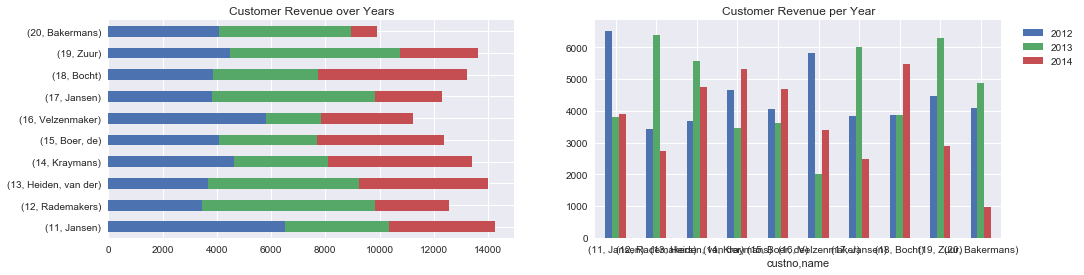

In [13]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,4))

df_.plot.barh(ax=ax0, stacked=True, legend=None)

df_.plot.bar(ax=ax1, rot=0)
ax1.legend(bbox_to_anchor=(1.2, 1))
ax0.set(title="Customer Revenue over Years", ylabel='')
ax1.set(title="Customer Revenue per Year");

It makes more sense to visualize each year in a separate chart

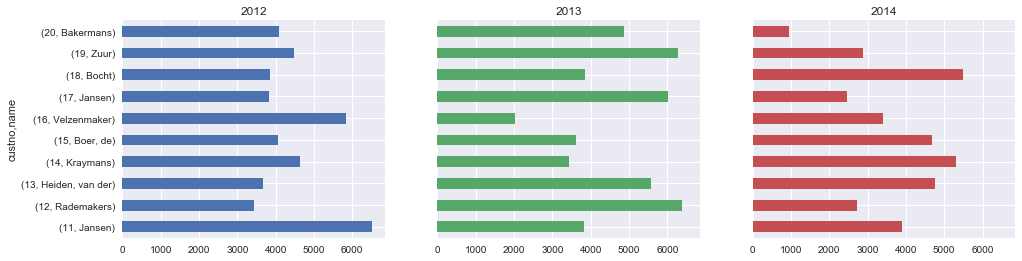

In [14]:
(df.groupby(['year', 'custno', 'name'])['linetotal']
 .sum()
 .unstack(level=0)
 .plot.barh(subplots=True, figsize=(16, 4), layout=(1,3), sharey=True, legend=False));

Of course we can base our plot on the SQL data frame just as well:

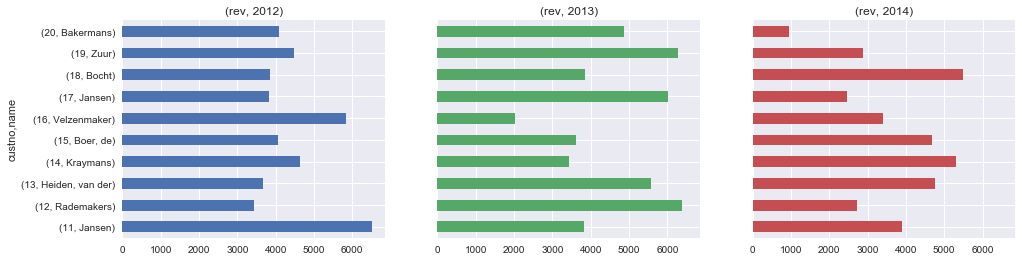

In [15]:
(pysqldf(qry)
 .set_index(['year', 'custno', 'name'])
 .unstack(level=0)
 .plot.barh(subplots=True, figsize=(16, 4), layout=(1,3), sharey=True, legend=False)); 

__What is the average order amount for each customer?__

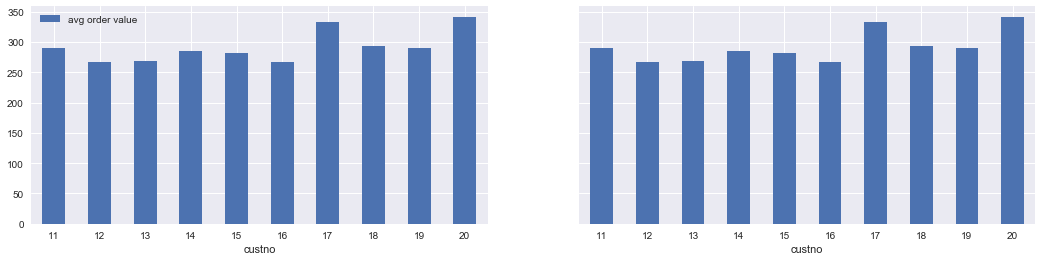

In [16]:
qry = """
with cte as (
    select custno, orderno, sum(linetotal) as ordtotal
    from df
    group by custno, orderno
)
select custno, avg(ordtotal) [avg order value]
from cte
group by custno
"""

_, ax = plt.subplots(1,2, sharey=True, figsize=(18,4))

pysqldf(qry).set_index('custno').plot.bar(ax=ax[0], rot=0)

# same using plain pandas:
(df.groupby(['custno', 'orderno'])['linetotal']
 .sum()
 .groupby('custno')
 .mean()
 .plot.bar(ax=ax[1], rot=0));

Now we will do something time related. To properly demonstrate pandas' time series functionality we will base our queries on the ```dat``` attribute. Of course it would be easier to base our queries on the time unit attributes that are already available in the data set.

We start with converting the ```dat``` column to a pandas datetime format.

Next we visualize revenue over time. We use sample using ```resample()``` on both daily and monthly base to group date values.

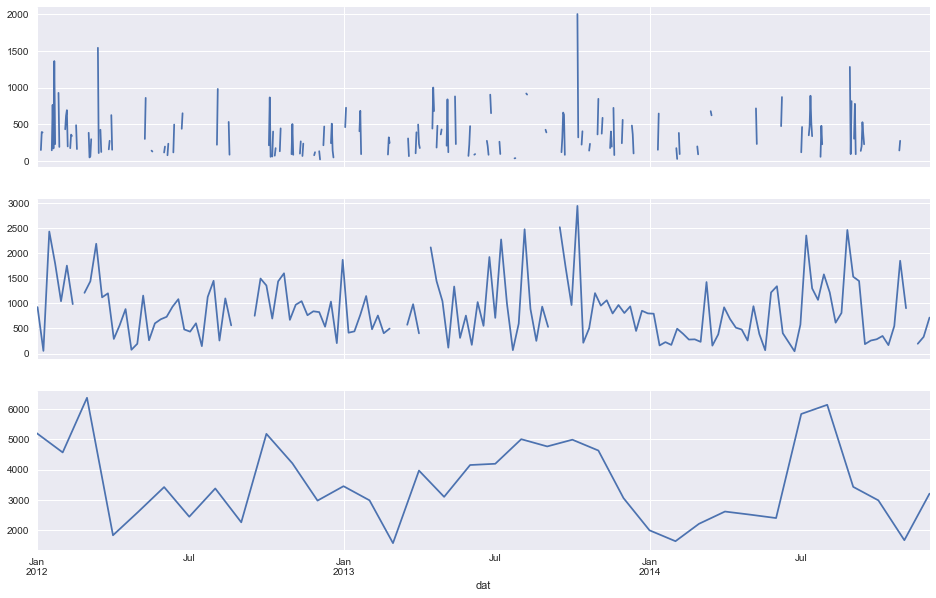

In [17]:
def plotSamples(samples=['D', 'W', 'M']):
    _, ax = plt.subplots(len(samples), 1, sharex=True, figsize=(16,10))

    for n, s in enumerate(samples):
        (df
         .resample(s, on='dat')['linetotal']
         .sum()
         .plot.line(ax=ax[n]))
        
plotSamples();

Note the misleading plt with annual values. The annual revenue seems confusingly attributed to the first date of the year

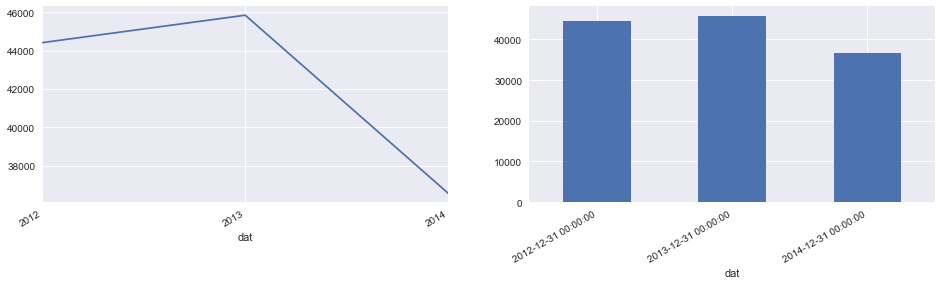

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

(df
 .resample('A', on='dat')['linetotal']
 .sum()
 .plot.line(ax=ax[0]))
(df
 .resample('A', on='dat')['linetotal']
 .sum()
 .plot.bar(ax=ax[1]))
plt.figure().autofmt_xdate()

fig.autofmt_xdate()

Alternatively with a ```groupby()``` and a ```Grouper()```:

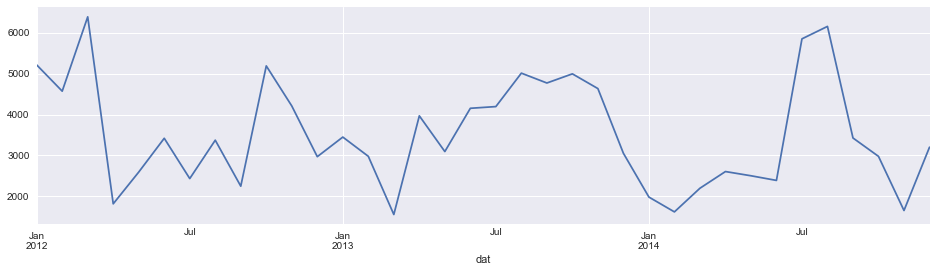

In [19]:
(df
 .groupby(pd.Grouper(key='dat', freq='M'))['linetotal']
 .sum()
 .plot.line(figsize=(16,4)));

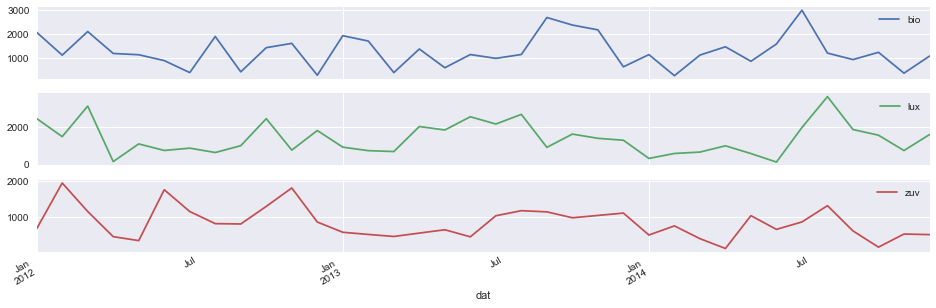

In [20]:
(df
 .groupby([pd.Grouper(key='dat', freq='M'), 'catcode'])['linetotal']
 .sum()
 .unstack(level=1)
 .plot.line(subplots=True, figsize=(16,5)));

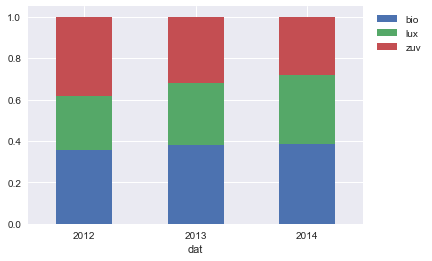

In [21]:
df_ = (df
       .groupby([pd.Grouper(key='dat', freq='A'), 'catcode'])
       .size()
       .unstack(level=1))
ax = (df_
      .div(df_.sum(axis=1), axis=0)
      .plot.bar(stacked=True))
# pfff, cost me at least an hour to get the chart right
ax.set_xticklabels(df_.index.year, rotation=0)
ax.legend(bbox_to_anchor=(1.2, 1));

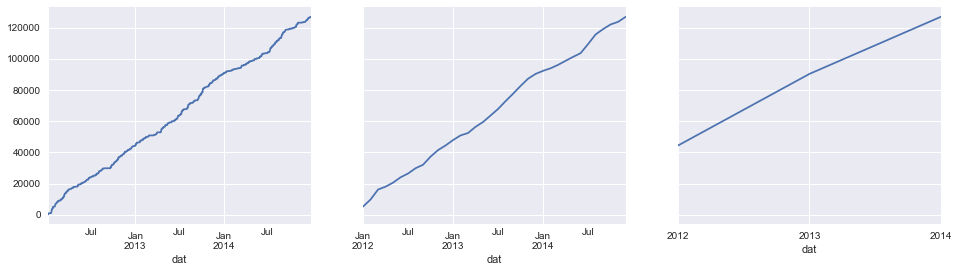

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(16,4))
(df.resample('D', on='dat')['linetotal']
 .sum()
 .fillna(0)
 .cumsum()
.plot(ax = ax0))
(df.resample('M', on='dat')['linetotal']
 .sum()
 .fillna(0)
 .cumsum()
 .plot(ax = ax1))
(df.resample('A', on='dat')['linetotal']
 .sum()
 .fillna(0)
 .cumsum()
 .plot.line(ax = ax2));

That is repetiton of code; we don't like that!. Let's make a function for it:

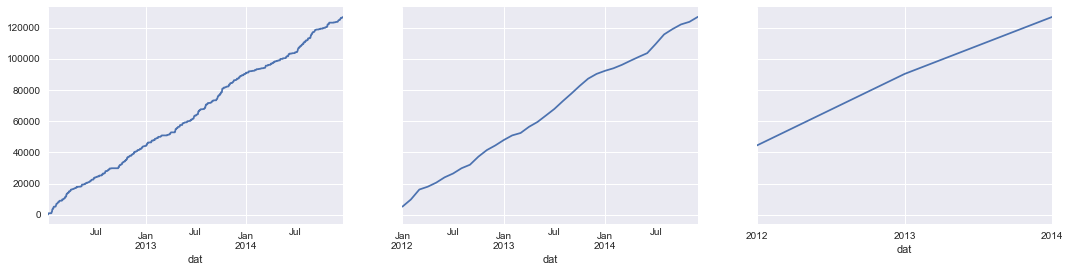

In [23]:
def plotter(ax, freq):
    (df.resample(freq, on='dat')['linetotal']
     .sum()
     .fillna(0)
     .cumsum()
     .plot.line(ax = ax))
    
_, ax = plt.subplots(1,3, sharey=True, figsize=(18,4))
for n, s in enumerate('DMA'):
    plotter(ax[n], s)

**What is for each year the monthly cumulative revenue?**

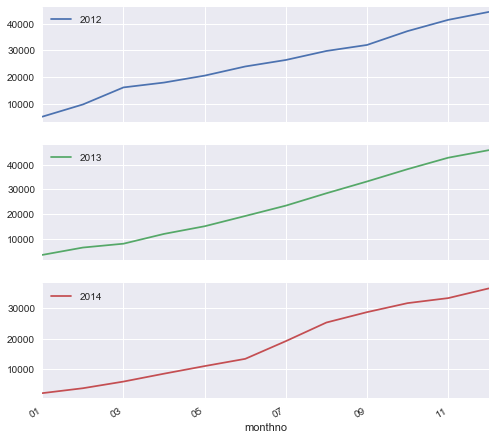

In [24]:
qry = """
with cte as (
select strftime('%Y', dat) as yr, strftime('%m', dat) as monthno, sum(linetotal) as total
from df
group by strftime('%Y', dat), strftime('%m', dat)
)
select c1.yr, c1.monthno
	, sum(case when c1.yr='2012' then c2.total end) as '2012'
	, sum(case when c1.yr='2013' then c2.total end) as '2013'
	, sum(case when c1.yr='2014' then c2.total end) as '2014'
from cte as c1
join cte as c2
	on c1.yr = c2.yr
	and c1.monthno >= c2.monthno
group by c1.monthno
"""

(pysqldf(qry)
 .set_index('monthno')
 .plot.line(subplots=True, figsize=(8,8)));

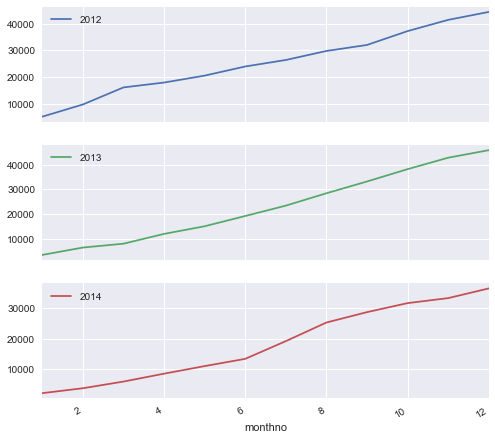

In [25]:
(df.groupby([df.dat.dt.year, df.dat.dt.month])['linetotal']
 .sum()
 .unstack(level=0)
 .cumsum()
 .rename_axis('monthno')
 .plot.line(subplots=True, figsize=(8,8)));

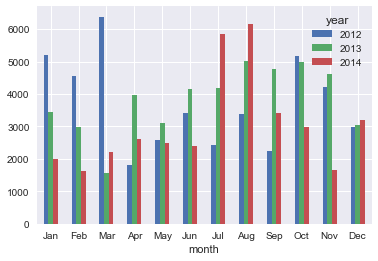

In [26]:
import calendar

ax = (pd.pivot_table(df,
               values='linetotal',
               index=df['dat'].dt.month.rename('month'),
               columns=df['dat'].dt.year.rename('year'),
               aggfunc=np.sum)
 .plot.bar())
months = [calendar.month_abbr[n] for n in range(1, 13)]
ax.set_xticklabels(months, rotation=0);

In [27]:
(df.groupby(pd.Grouper(key='dat', freq='D'))['linetotal']
 .sum()
 .cumsum()
 .ffill()['20140430'])

98686.95000000007

In [28]:
ser = (df.groupby(pd.Grouper(key='dat', freq='D'))['linetotal']
       .sum())
print("2013-04-30 YTD: ", ser['20130101':'20140101'].cumsum().ffill()['20130430'])
print("2014-04-30 YTD: ", ser['20140101':'20150101'].cumsum().ffill()['20140430'])

2013-04-30 YTD:  11954.65
2014-04-30 YTD:  8414.7


In [29]:
df_ = (df.resample('D', on='dat')['linetotal']
       .sum()
       .reindex(index=pd.DatetimeIndex(start='20120101', end='20141231', freq='D'))
       .fillna(0)
       .to_frame())
df_ = (df_.set_index([df_.index.year, df_.index.month, df_.index.day])
       .unstack(level=0, fill_value=0)
       .cumsum())
df_.index.rename(['monthno', 'day'], inplace=True)
df_.columns = list(df_.columns.levels[1])
df_.columns.name ='year'
df_.name = 'YTD'
df_.head()

year         2012     2013   2014
monthno day                      
1       1     0.0     0.00  322.5
        2     0.0     0.00  322.5
        3     0.0   458.85  801.3
        4     0.0  1182.90  801.3
        5     0.0  1182.90  801.3

In [30]:
print("2013-04-30 YTD: ", df_.loc[4, 30][2013])
print(df_.loc[(4, 30), 2013])
df_.loc[(4, 30), :]

2013-04-30 YTD:  11954.65
11954.65


year
2012    17982.80
2013    11954.65
2014     8414.70
Name: (4, 30), dtype: float64

In [31]:
(df.groupby(pd.Grouper(key='dat', freq='M'))['linetotal']
 .sum()
 .cumsum()[:5])

dat
2012-01-31     5209.90
2012-02-29     9779.45
2012-03-31    16163.00
2012-04-30    17982.80
2012-05-31    20577.65
Freq: M, Name: linetotal, dtype: float64

**What is the monthly percentual contribution to revenue of each product catagory?**

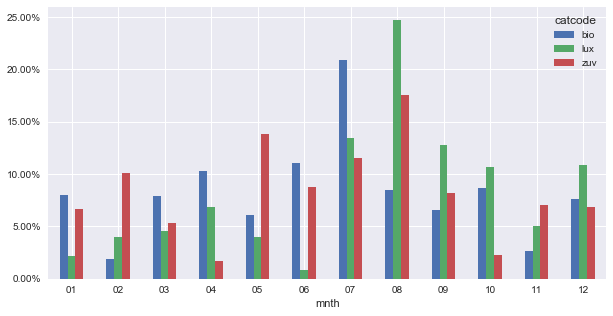

In [32]:
qry = """
with cte as (
select catcode, sum(linetotal) as total2014
from df
where year = '2014'
group by catcode
)
select strftime('%m', dat) as mnth, df.catcode, sum(linetotal)/min(total2014) as [%ofCatTotal]
from df
join cte
    on df.catcode = cte.catcode
where year = '2014'
group by 1, 2
"""

df_ = (pysqldf(qry)
      .set_index(['mnth', 'catcode'])
      .unstack())
df_.columns = df_.columns.droplevel()
ax = df_.plot.bar(figsize=(10,5), rot=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals]);

Note that in T-SQL (or any other SQL dialect supporting windowing functions) we would have solved this using a windowing function:

```sql
select monthNo, df.catcode
    , sum(lineTotal)/(sum(sum(lineTotal) over (partition by catcode)) as [%ofCatTotal]
from df
where year = '2014'
group by monthNo, catcode
```

In plain pandas we can accomplish the same using:

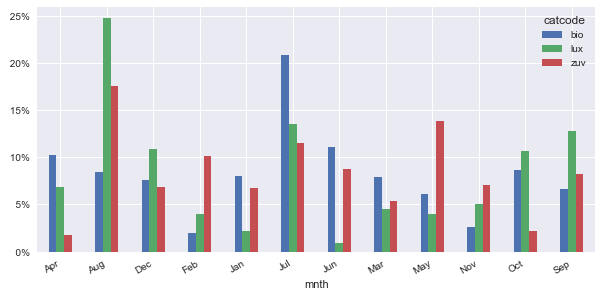

In [33]:
ax = (df[df['year'] == 2014]
      .groupby(['year', 'mnth', 'catcode'])['linetotal']
      .sum()
      .unstack()
      .groupby('year')
      .transform(lambda x: x/x.sum())
      .reset_index(level=0, drop=True)
      .plot.bar(figsize=(10,5)))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.figure.autofmt_xdate()

That's nog good: the x-axis is sorted alphabetically. Let's solve this by mapping dates in the index to month names.

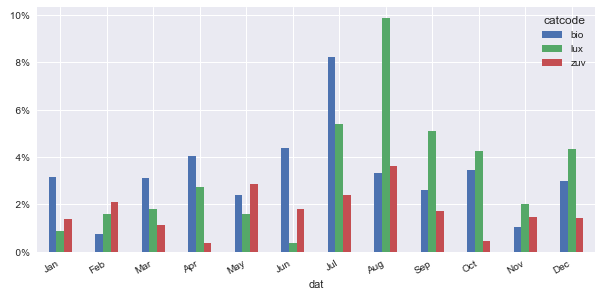

In [34]:
ax = (df[df['year'] == 2014]
      .groupby([pd.Grouper(key='dat', freq='M'), 'catcode'])['linetotal']
      .sum()
      .groupby(pd.Grouper(level='dat', freq='A'))
      .transform(lambda x: x/x.sum())
      .unstack()
      .rename(index=lambda x: x.strftime('%b'))
      .plot.bar(figsize=(10,5)))

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

ax.figure.autofmt_xdate()

We can also solve the x-axis label issue in matplotlib:

ValueError: Invalid format specifier

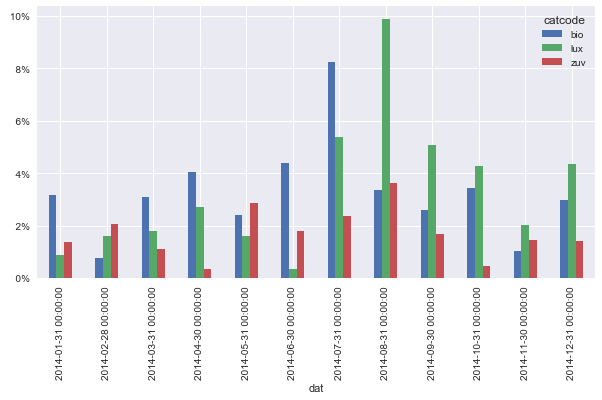

In [40]:
df_ = (df[df['year'] == 2014]
      .groupby([pd.Grouper(key='dat', freq='M'), 'catcode'])['linetotal']
      .sum()
      .groupby(pd.Grouper(level='dat', freq='A'))
      .transform(lambda x: x/x.sum())
      .unstack())
ax = df_.plot.bar(figsize=(10,5))

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

dats = ax.get_xticks()
ax.set_xticklabels(['{:%Y-%m-%d}'.format(x) for x in dats])

ax.figure.autofmt_xdate()

That's  better. X-axis is ok, bars are isomorphic, but ... different percentage values. What is wrong?

**Count the number of customers in each customer class based on the customer's average order value.**

Class A customers have an average order value over 293, class C customers below 280. All other customers belong to class B.

In [ ]:
qry = """
with cte1 as (
select custno, orderno, sum(lineTotal) as ordval
from df
group by custno, orderno
), cte2 as (
select sum(ordval)/count(ordval) as avgOrdval
from cte1
group by custno
)
select
	count(case when avgOrdval < 280 then 1 end) as 'A',
	count(case when avgOrdval between 280 and 292 then 1 end) as 'B',
	count(case when avgOrdval > 292 then 1 end) as 'C'
from cte2
"""

pysqldf(qry).T.plot.bar(legend=False, rot=0);

This odd looking query is a good demonstration of the expressive power of pandas:

In [ ]:
df.groupby('orderno')['linetotal'].sum().plot.hist();

**Visualize each customer's order value distribution in a box plot.**

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
sns.boxplot(
    y='custno', x='linetotal',
    data=df.groupby(['custno', 'orderno'])['linetotal'].sum().reset_index(),
    orient='h', color='grey');

**Visualize yearly variance in order value**

In [ ]:
(df.groupby(['dat', 'orderno'])['linetotal']
 .sum()
 .groupby('dat')
 .mean()
 .plot.line(figsize=(16,4)));

Not much seasonality here. (Couldn't be expected as the data has been generated using a uniform randomizer.)

In [ ]:
(pd.crosstab(df['dat'].dt.to_period('A'), df['custno'])
 .T
 .plot.bar(rot=0));


We can also normalize (take the percentage of row/column total, in Excel terminology) the results of a crosstab operation:

In [ ]:
pd.crosstab(df['dat'].dt.to_period('M'), df['custno'], normalize='index')['2014'][11]


In [ ]:
(pd.crosstab(df['dat'].dt.to_period('M'), df['custno'])
 .plot.line(subplots=True, figsize=(12,12)));

In [ ]:
ser_ = df[df['dat']>='20140101'].set_index('dat')['linetotal']

In [ ]:
ser1 = pd.Series(range(1, 5), index=pd.to_datetime(['20170901', '20170902', '20170902', '20170904']))
print(ser1, '\n')

ser2 = pd.Series(range(11, 16), index=pd.to_datetime(['20170901', '20170901', '20170904', '20170906', '20170908']))
print(ser2)

In [ ]:
pd.concat((ser1, ser2)).resample('D').sum().fillna(0)

In [ ]:
pd.concat((ser1.resample('D').sum().fillna(0), ser2.resample('D').sum().fillna(0)), axis=1).fillna(0)

You want to find out if there is a relationship between daily sales and percipitation. You business is closed in weekends. Some weekdays you don't sell anything at all. Set up the proper dataframe.

In [ ]:
rng = np.random.RandomState(33)

ser1 = pd.Series(rng.randint(10, 30, 4), index=pd.to_datetime(['20170901', '20170905', '20170905', '20170906']), name='sales')
print(ser1, '\n')

ser2 = pd.Series(np.random.rand(7), index=pd.date_range('20170901', '20170907'), name='percipitation')
print(ser2)

In [ ]:
# ser2 is on unique daily base; no need to resample and aggregate
pd.concat((ser1.resample('B').sum().fillna(0), ser2.asfreq('B')), axis=1).fillna(0)

Now let's scale up this technique to a longer period of time.

In [ ]:
# set an anchor date
startdate = np.array('2017-09-01', dtype=np.datetime64)

# create 1000 random sales events in a period of 800 days
ndx = (pd.DatetimeIndex(startdate + rng.randint(800, size=1000))).sort_values()

# get rid of the weekend days
ndx = ndx[ndx.dayofweek<5]

print("size:       ", ndx.size)
print("min:        ", ndx.min())
print("max:        ", ndx.max())
print("nr of days: ", (ndx.max() - ndx.min()).days + 1)

In [ ]:
ser1 = pd.Series(rng.randint(10, 150, size=ndx.size), index=ndx, name='sales')
ser2 = pd.Series(np.random.rand((ndx.max() - ndx.min()).days + 1), index=pd.date_range(ndx.min(), ndx.max()), name='percipitation')

df1 = pd.concat((ser1.resample('B').sum().fillna(0), ser2.resample('B').sum()), axis=1).fillna(0)

#df.plot.scatter(x='percipitation', y='sales');
sns.regplot(x='percipitation', y='sales', data=df1)

In [ ]:
df1.corr(method='pearson').loc['percipitation', 'sales']

Now let's fabricate a relationship between participation and sales:

In [ ]:
df1 = ser2.asfreq('B').to_frame()
df1['sales'] = 100 * df1['percipitation']
jitter = np.absolute(rng.normal(loc=20, scale=20, size=df1['sales'].size)) + rng.randint(-8, 20, df1['sales'].size)
df1['sales'] += jitter
sns.regplot(x='percipitation', y='sales', data=df1);

In [ ]:
df1.corr(method='pearson').loc['percipitation', 'sales']

In [ ]:
pd.to_datetime('20170901') + pd.to_timedelta(np.sort(rng.randint(1, 365, size=300)), 'D')


In [ ]:
ax = (pd.cut(df.groupby('orderno')['linetotal'].sum(),
             bins=[0, 125, 200, 350, 500, 1000],
             labels=['ditch', 'pff', 'low', 'ok', 'great'])
      .value_counts(normalize=True)
      .sort_index()
      .plot.bar(rot=0))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);